<a href="https://colab.research.google.com/github/kelgruber/bear-cnn-classification/blob/main/Kel_Gruber_Final_Task_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Final Project Task 5: Using Pre-trained Models and Recent Architectures

Kel Gruber

## Dataset - Hand Gesture Classification

Goal of this project is build a model that correctly classifies images of 5 different hand gestures. Dataset consists of over 2650 digital colored images that belong to 5 classes: dislike, like, peace, one, and stop. 2500 images came from the crowdsourced HaGRID dataset and 150 images were taken by Kel Gruber and classmate volunteers following the Hagrid dataset's collection guidelines.

The 2500 images originally came from this [HaGRID Sample 30k 384p Dataset](https://www.kaggle.com/datasets/innominate817/hagrid-sample-30k-384p) on Kaggle, this sample contains 30,000 images and all 18 classes.

##1. Load Dataset and Preview Images
For reproducibility the dataset has been split before we begin into 3 sets, the training, validation and testing sets. The training set contains approximately 60% of the data, and the validation and testing sets each contain 20% of the data.

This task will be completed with the revised dataset from Task 1 with the cropped images. As shown in the Task 1 experiments the original data requires very deep models to learn due to the complexity of the complexity of the original images.

### Import libaries and connect to Drive

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


###Import Dataset from Drive and Unzip

In [ ]:
import zipfile
import os
zip_train = zipfile.ZipFile('/content/drive/MyDrive/Colab Notebooks/5390 Final Project/Cropped_Split_Data.zip')
zip_train.extractall('/tmp')
zip_train.close()

###Import Training, Validation, and Testing Datasets

In [ ]:
image_size = 224

image_generator = ImageDataGenerator(rescale=1./255)

training_data = image_generator.flow_from_directory( '/tmp/Cropped_Split_Data/training', target_size=(image_size , image_size), batch_size=1, class_mode='categorical')
print(training_data.image_shape)

validation_set = image_generator.flow_from_directory( '/tmp/Cropped_Split_Data/validation', target_size=(image_size , image_size ), batch_size=1, class_mode='categorical')
print(validation_set.image_shape)

testing_set = image_generator.flow_from_directory( '/tmp/Cropped_Split_Data/testing', target_size=(image_size , image_size), batch_size=1, class_mode='categorical')
print(testing_set.image_shape)

Found 1590 images belonging to 5 classes.
(224, 224, 3)
Found 530 images belonging to 5 classes.
(224, 224, 3)
Found 530 images belonging to 5 classes.
(224, 224, 3)


###View Some Examples from the Training Dataset

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

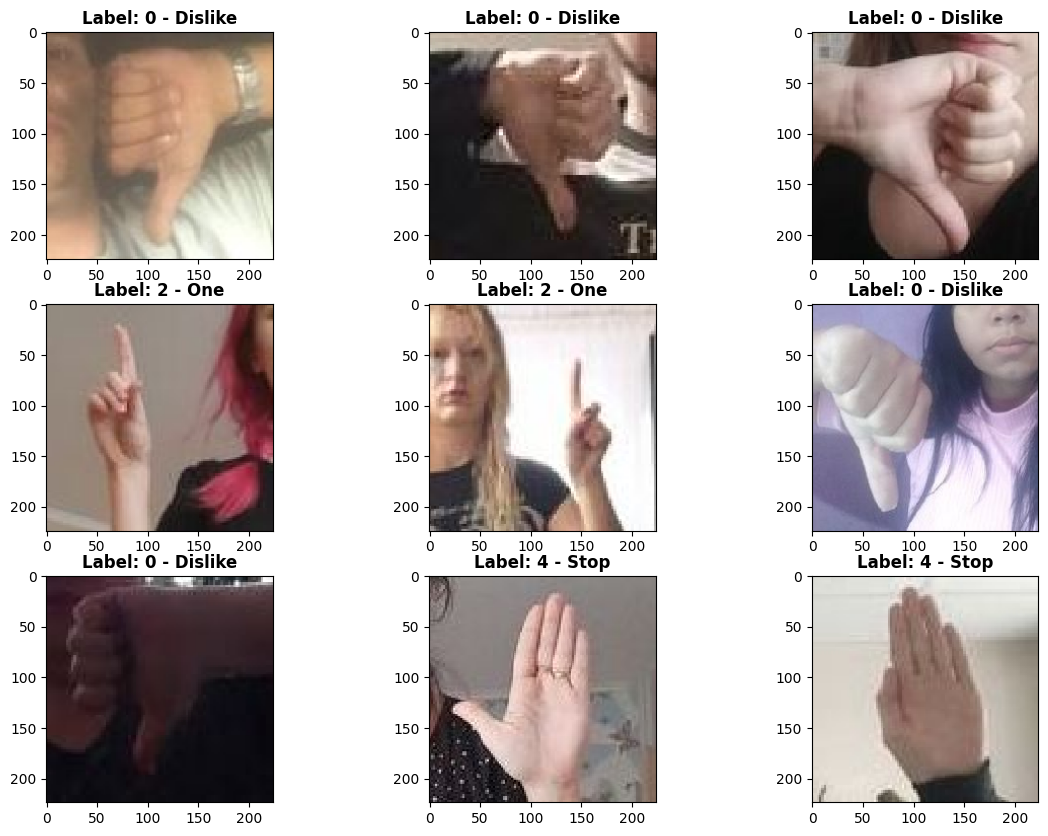

In [ ]:
i = 3
label_category = {0: "Dislike", 1: "Like", 2: "One", 3: "Peace", 4: "Stop"}

images = []
labels = []
for i in range(9):
    image, label = next(training_data)
    images.append(image)
    labels.append(label)

labels = np.array(labels)
labels = np.squeeze(labels)
labels = np.argmax(labels, axis=1)
labels = list(labels)

# Plotting the images
plt.figure(figsize=(14,10))
for i in range(0,9):
    row = i // 3  # Calculate row index
    column = i % 3  # Calculate column index
    plt.subplot(3, 3, i + 1)
    plt.title(f'Label: {labels[i]} - {label_category[labels[i]]}',fontweight='bold')
    plt.imshow(images[i].squeeze())
plt.show()

##2. Using Pre-trained Models

Our goal in this phase is to improve our accuracy on the validation set but using more powerful architectures such as ResNet, DenseNet, or NASNet, and using pre-trained models such as VGG16 or ResNet50.

In [ ]:
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten
from tensorflow.keras.applications import VGG16, DenseNet121, ResNet50
import time

###2.1 VGG16

####Load and Preview Model Base

In [ ]:
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))
vgg_base.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

####Train Model

In [ ]:
import re
vgg_base.trainable = False
for layer in vgg_base.layers:
    if bool(re.search('block5',layer.name)):
      layer.trainable = True
      print(layer.name,": Trainable")

block5_conv1 : Trainable
block5_conv2 : Trainable
block5_conv3 : Trainable
block5_pool : Trainable


In [ ]:
model_V2 = Sequential()
model_V2.add( vgg_base )
model_V2.add( Flatten() )
model_V2.add( Dense(units=64, activation = 'relu' , input_dim = 7 * 7 * 512) )
model_V2.add( layers.Dropout(0.4) )
model_V2.add( Dense(units=5, activation = 'softmax' ) )
model_V2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 64)                1605696   
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 5)                 325       
                                                                 
Total params: 16320709 (62.26 MB)
Trainable params: 1606021 (6.13 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [ ]:
start_time = time.time()
callback_b = EarlyStopping(monitor='val_loss', mode='min', patience = 20, verbose=1)
model_V2.compile( optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = 'accuracy')
model_V2_history = model_V2.fit( training_data, validation_data = validation_set, epochs = 100, batch_size = 64, callbacks = [callback_b])
end_time = time.time()

Epoch 1/100
1590/1590 [==============================] - 27s 14ms/step - loss: 1.6399 - accuracy: 0.3409 - val_loss: 1.2269 - val_accuracy: 0.4962
Epoch 2/100
1590/1590 [==============================] - 22s 14ms/step - loss: 1.3312 - accuracy: 0.4176 - val_loss: 1.0934 - val_accuracy: 0.5208
Epoch 3/100
1590/1590 [==============================] - 23s 14ms/step - loss: 1.2444 - accuracy: 0.4818 - val_loss: 0.9684 - val_accuracy: 0.5755
Epoch 4/100
1590/1590 [==============================] - 25s 16ms/step - loss: 1.0831 - accuracy: 0.5679 - val_loss: 0.7386 - val_accuracy: 0.7226
Epoch 5/100
1590/1590 [==============================] - 29s 18ms/step - loss: 0.9716 - accuracy: 0.6214 - val_loss: 0.8360 - val_accuracy: 0.7038
Epoch 6/100
1590/1590 [==============================] - 24s 15ms/step - loss: 0.8944 - accuracy: 0.6717 - val_loss: 0.5875 - val_accuracy: 0.8189
Epoch 7/100
1590/1590 [==============================] - 23s 14ms/step - loss: 0.9030 - accuracy: 0.6774 - val_loss: 0

In [ ]:
print(f"Training time: {(end_time - start_time)/60} minutes.")

Training time: 13.754043904940287 minutes.


####View Learning Curves

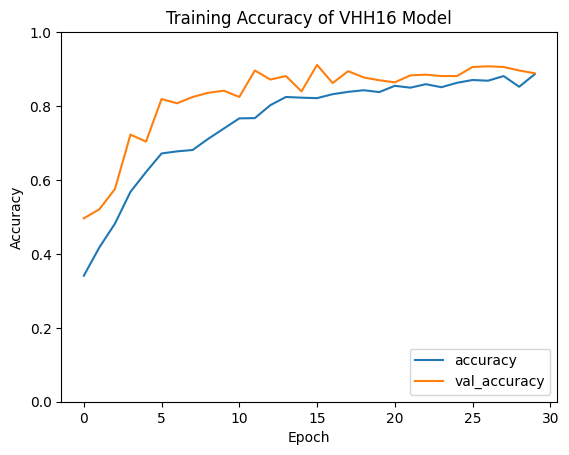

In [ ]:
plt.title('Training Accuracy of VHH16 Model')
plt.plot(model_V2_history.history['accuracy'], label='accuracy')
plt.plot(model_V2_history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

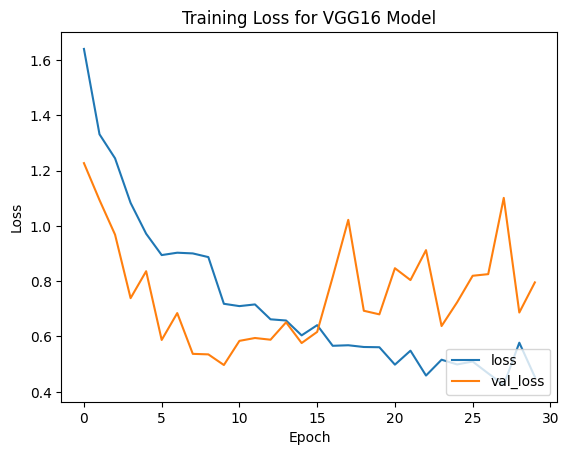

In [ ]:
plt.title('Training Loss for VGG16 Model')
plt.plot(model_V2_history.history['loss'], label='loss')
plt.plot(model_V2_history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')
plt.show()

In [ ]:
val_loss, val_acc = model_V2.evaluate(validation_set)

print(f'Accuracy: {val_acc*100.0}')
print(f'Loss:{val_loss}')

530/530 [==============================] - 5s 10ms/step - loss: 0.7956 - accuracy: 0.8887
Accuracy: 88.86792659759521
Loss:0.7956214547157288


####Evaluate Model

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [ ]:
# Get predictions from model
P = [] # empty list of predictions
Y_true = []
for i in range(len(validation_set)):
   x, y = validation_set.next()
   p = model_V2.predict(x, verbose = 0)
   Y_true.extend(y)
   P.extend(p)

In [ ]:
# Convert predicted probabilities to binary predictions (0 or 1)
Y_pred = np.argmax(P, axis=1)
Y_true = np.argmax(Y_true, axis=1)

accuracy = accuracy_score(Y_true, Y_pred)
precision = precision_score(Y_true, Y_pred, average='weighted')
recall = recall_score(Y_true, Y_pred, average='weighted')
f1 = f1_score(Y_true, Y_pred, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.8886792452830189
Precision: 0.8878303443472904
Recall: 0.8886792452830189
F1 Score: 0.8879336942769246


###2.2 DenseNet121


####Load and Preview Model Base

In [ ]:
dense_base = DenseNet121(weights='imagenet', include_top=False, input_shape=(224,224,3))
dense_base.summary()

29084464/29084464 [==============================] - 0s 0us/step
Model: "densenet121"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 230, 230, 3)          0         ['input_2[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 112, 112, 64)         9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormali

####Train Model

In [ ]:
import re
dense_base.trainable = False
for layer in dense_base.layers:
    if bool(re.search('conv5',layer.name)):
      layer.trainable = True
      print(layer.name,": Trainable")

conv5_block1_0_bn : Trainable
conv5_block1_0_relu : Trainable
conv5_block1_1_conv : Trainable
conv5_block1_1_bn : Trainable
conv5_block1_1_relu : Trainable
conv5_block1_2_conv : Trainable
conv5_block1_concat : Trainable
conv5_block2_0_bn : Trainable
conv5_block2_0_relu : Trainable
conv5_block2_1_conv : Trainable
conv5_block2_1_bn : Trainable
conv5_block2_1_relu : Trainable
conv5_block2_2_conv : Trainable
conv5_block2_concat : Trainable
conv5_block3_0_bn : Trainable
conv5_block3_0_relu : Trainable
conv5_block3_1_conv : Trainable
conv5_block3_1_bn : Trainable
conv5_block3_1_relu : Trainable
conv5_block3_2_conv : Trainable
conv5_block3_concat : Trainable
conv5_block4_0_bn : Trainable
conv5_block4_0_relu : Trainable
conv5_block4_1_conv : Trainable
conv5_block4_1_bn : Trainable
conv5_block4_1_relu : Trainable
conv5_block4_2_conv : Trainable
conv5_block4_concat : Trainable
conv5_block5_0_bn : Trainable
conv5_block5_0_relu : Trainable
conv5_block5_1_conv : Trainable
conv5_block5_1_bn : Traina

In [ ]:
model_D = Sequential()
model_D.add( dense_base)
model_D.add( Flatten())
model_D.add( Dense(units=25, activation = 'relu' , input_dim = 7 * 7 * 1920))
model_D.add( Dense(units=5, activation = 'softmax' ) )
model_D.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 flatten_1 (Flatten)         (None, 50176)             0         
                                                                 
 dense_2 (Dense)             (None, 25)                1254425   
                                                                 
 dense_3 (Dense)             (None, 5)                 130       
                                                                 
Total params: 8292059 (31.63 MB)
Trainable params: 1254555 (4.79 MB)
Non-trainable params: 7037504 (26.85 MB)
_________________________________________________________________


In [ ]:
start_time = time.time()
callback_b = EarlyStopping(monitor='val_loss', mode='min', patience = 20, verbose=1)
model_D.compile( optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = 'accuracy')
model_D_history = model_D.fit( training_data,  validation_data = validation_set, epochs = 100, batch_size = 64, callbacks = [callback_b])
end_time = time.time()

Epoch 1/100
1590/1590 [==============================] - 53s 28ms/step - loss: 1.6769 - accuracy: 0.5547 - val_loss: 1.0460 - val_accuracy: 0.6679
Epoch 2/100
1590/1590 [==============================] - 34s 22ms/step - loss: 0.7248 - accuracy: 0.7604 - val_loss: 0.6572 - val_accuracy: 0.7887
Epoch 3/100
1590/1590 [==============================] - 37s 23ms/step - loss: 0.5816 - accuracy: 0.7969 - val_loss: 1.0264 - val_accuracy: 0.8038
Epoch 4/100
1590/1590 [==============================] - 38s 24ms/step - loss: 0.4069 - accuracy: 0.8805 - val_loss: 0.4184 - val_accuracy: 0.8472
Epoch 5/100
1590/1590 [==============================] - 36s 23ms/step - loss: 0.3751 - accuracy: 0.9233 - val_loss: 0.6109 - val_accuracy: 0.8358
Epoch 6/100
1590/1590 [==============================] - 34s 22ms/step - loss: 0.2270 - accuracy: 0.9453 - val_loss: 0.4481 - val_accuracy: 0.8717
Epoch 7/100
1590/1590 [==============================] - 38s 24ms/step - loss: 0.1388 - accuracy: 0.9679 - val_loss: 0

In [ ]:
print(f"Training time: {(end_time - start_time)/60} minutes.")

Training time: 15.220720628897348 minutes.


####View Learning Curves

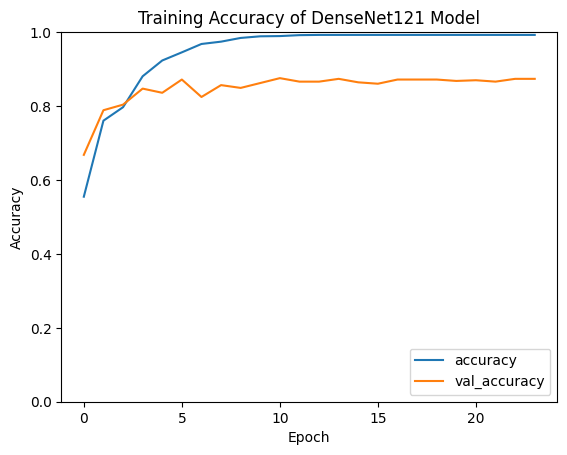

In [ ]:
plt.title('Training Accuracy of DenseNet121 Model')
plt.plot(model_D_history.history['accuracy'], label='accuracy')
plt.plot(model_D_history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

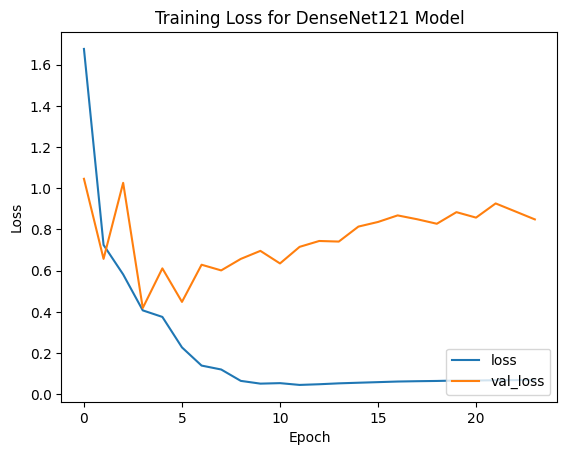

In [ ]:
plt.title('Training Loss for DenseNet121 Model')
plt.plot(model_D_history.history['loss'], label='loss')
plt.plot(model_D_history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')
plt.show()

####Evaluate Model

In [ ]:
val_loss, val_acc = model_D.evaluate(validation_set)

print(f'Accuracy: {val_acc*100.0}')
print(f'Loss:{val_loss}')

530/530 [==============================] - 9s 17ms/step - loss: 0.8488 - accuracy: 0.8736
Accuracy: 87.35849261283875
Loss:0.8488165140151978


In [ ]:
# Get predictions from model
P = [] # empty list of predictions
Y_true = []
for i in range(len(validation_set)):
   x, y = validation_set.next()
   p = model_D.predict(x, verbose = 0)
   Y_true.extend(y)
   P.extend(p)

In [ ]:
# Convert predicted probabilities to binary predictions (0 or 1)
Y_pred = np.argmax(P, axis=1)
Y_true = np.argmax(Y_true, axis=1)

accuracy = accuracy_score(Y_true, Y_pred)
precision = precision_score(Y_true, Y_pred, average='weighted')
recall = recall_score(Y_true, Y_pred, average='weighted')
f1 = f1_score(Y_true, Y_pred, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.8735849056603774
Precision: 0.9039556240029109
Recall: 0.8735849056603774
F1 Score: 0.8788113718118866


###2.3 MobileNetV2


####Load and Preview Model Base

In [ ]:
from tensorflow.keras.applications import MobileNetV2

In [ ]:
mobilenet_base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3))
mobilenet_base.summary()

9406464/9406464 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_4[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReL

####Train Model

In [ ]:
import re
mobilenet_base.trainable = False
for layer in mobilenet_base.layers:
    if bool(re.search('block_16',layer.name)):
      layer.trainable = True
      print(layer.name,": Trainable")

block_16_expand : Trainable
block_16_expand_BN : Trainable
block_16_expand_relu : Trainable
block_16_depthwise : Trainable
block_16_depthwise_BN : Trainable
block_16_depthwise_relu : Trainable
block_16_project : Trainable
block_16_project_BN : Trainable


In [ ]:
model_M = Sequential()
model_M.add( mobilenet_base)
model_M.add( Flatten())
model_M.add( Dense(units=25, activation = 'relu' , input_dim = 7 * 7 * 1280))
model_M.add(layers.Dropout(0.5))
model_M.add( Dense(units=5, activation = 'softmax' ) )
model_M.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 flatten_6 (Flatten)         (None, 62720)             0         
                                                                 
 dense_12 (Dense)            (None, 25)                1568025   
                                                                 
 dropout_7 (Dropout)         (None, 25)                0         
                                                                 
 dense_13 (Dense)            (None, 5)                 130       
                                                                 
Total params: 3826139 (14.60 MB)
Trainable params: 1568155 (5.98 MB)
Non-trainable params: 2257984 (8.61 MB)
___________

In [ ]:
start_time = time.time()
callback_b = EarlyStopping(monitor='val_loss', mode='min', patience = 20, verbose=1)
model_M.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = 'accuracy')
model_M_history = model_M.fit(training_data, validation_data = validation_set, epochs = 100, batch_size = 64, callbacks = [callback_b])
end_time = time.time()

Epoch 1/100
1590/1590 [==============================] - 24s 13ms/step - loss: 2.0128 - accuracy: 0.2767 - val_loss: 1.9256 - val_accuracy: 0.3698
Epoch 2/100
1590/1590 [==============================] - 19s 12ms/step - loss: 1.7075 - accuracy: 0.3572 - val_loss: 1.0407 - val_accuracy: 0.5943
Epoch 3/100
1590/1590 [==============================] - 18s 11ms/step - loss: 1.5056 - accuracy: 0.4176 - val_loss: 1.0102 - val_accuracy: 0.6453
Epoch 4/100
1590/1590 [==============================] - 20s 13ms/step - loss: 1.4156 - accuracy: 0.4717 - val_loss: 1.2876 - val_accuracy: 0.6340
Epoch 5/100
1590/1590 [==============================] - 19s 12ms/step - loss: 1.2872 - accuracy: 0.4855 - val_loss: 1.0975 - val_accuracy: 0.6736
Epoch 6/100
1590/1590 [==============================] - 20s 13ms/step - loss: 1.2181 - accuracy: 0.4843 - val_loss: 0.9941 - val_accuracy: 0.7019
Epoch 7/100
1590/1590 [==============================] - 18s 12ms/step - loss: 1.1902 - accuracy: 0.5214 - val_loss: 1

In [ ]:
print(f"Training time: {(end_time - start_time)/60} minutes.")

Training time: 9.968756330013274 minutes.


####View Learning Curves

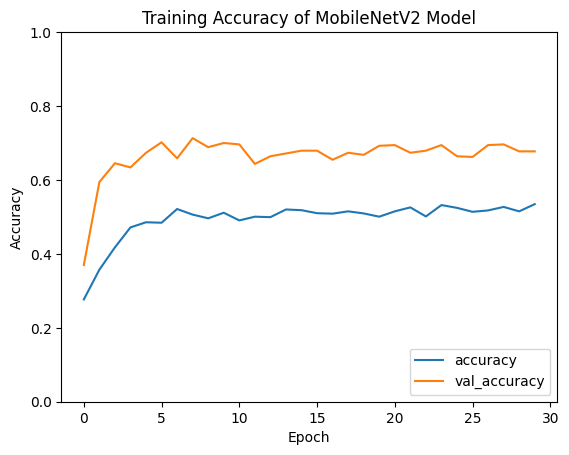

In [ ]:
plt.title('Training Accuracy of MobileNetV2 Model')
plt.plot(model_M_history.history['accuracy'], label='accuracy')
plt.plot(model_M_history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

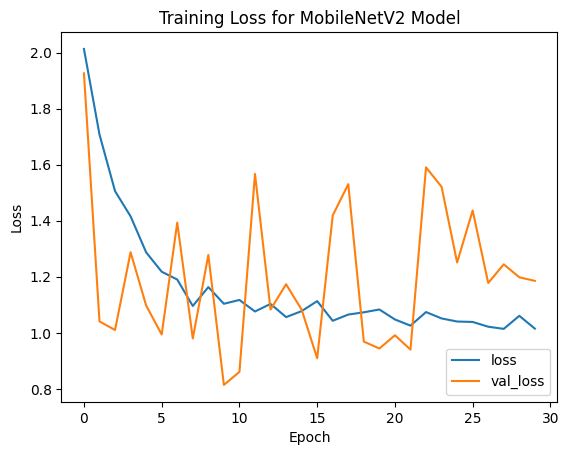

In [ ]:
plt.title('Training Loss for MobileNetV2 Model')
plt.plot(model_M_history.history['loss'], label='loss')
plt.plot(model_M_history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')
plt.show()

####Evaluate Model

In [ ]:
val_loss, val_acc = model_M.evaluate(validation_set)

print(f'Accuracy: {val_acc*100.0}')
print(f'Loss:{val_loss}')

530/530 [==============================] - 5s 9ms/step - loss: 1.1854 - accuracy: 0.6774
Accuracy: 67.73585081100464
Loss:1.1853796243667603


In [ ]:
# Get predictions from model
P = [] # empty list of predictions
Y_true = []
for i in range(len(validation_set)):
   x, y = validation_set.next()
   p = model_M.predict(x, verbose = 0)
   Y_true.extend(y)
   P.extend(p)

In [ ]:
# Convert predicted probabilities to binary predictions (0 or 1)
Y_pred = np.argmax(P, axis=1)
Y_true = np.argmax(Y_true, axis=1)

accuracy = accuracy_score(Y_true, Y_pred)
precision = precision_score(Y_true, Y_pred, average='weighted')
recall = recall_score(Y_true, Y_pred, average='weighted')
f1 = f1_score(Y_true, Y_pred, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.6773584905660377
Precision: 0.6808322497018385
Recall: 0.6773584905660377
F1 Score: 0.6290627400232597
